In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import LambdaCDM

(35.0, 50.0)

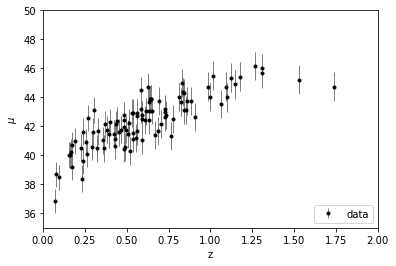

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [3]:
z = np.linspace(0.01, 2, 1000)

Let's do some cross validation

In [4]:
from sklearn.model_selection import train_test_split

mu = np.array([mu_sample, dmu]).T

z_train, z_val, mudmu_train, mudmu_val = train_test_split(z_sample[:, np.newaxis], mu, test_size=0.3, random_state=42)
mu_train, dmu_train = mudmu_train.T
mu_val, dmu_val = mudmu_val.T

In [5]:
def geterror(X, y, classifier):
    
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    
    classifier.fit(z_train, mu_train)
    error_train = geterror(z_train, mu_train, classifier)
    error_validation  = geterror(z_val, mu_val, classifier)
    return error_train, error_validation

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

c_values = np.linspace(0.1, 10, 20)
k_values = np.linspace(0.1, 10, 20)

err_train, err_test = [], []

for c in c_values:
    for k in k_values:
        
        kernel = ConstantKernel(c, constant_value_bounds='fixed') * RBF(k, length_scale_bounds='fixed')
        classifier = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True, optimizer=None)
        
        error_train, error_validation = fitanderror(classifier)
        err_train.append((c, k, error_train))
        err_test.append((c, k, error_validation))

# minimum validation error
best_idx = np.argmin([e[2] for e in err_test])
best_c, best_k, min_error = err_test[best_idx]

print(f'Best c: {best_c}, Best k: {best_k}, Min Validation Error: {min_error}')

Best c: 1.6631578947368424, Best k: 1.6631578947368424, Min Validation Error: 0.8052256819431334


<Figure size 720x576 with 0 Axes>

In [ ]:
kernel = ConstantKernel(best_c) * RBF(best_k)
gp = GaussianProcessRegressor(kernel=kernel, alpha = dmu**2)
gp.fit(z_sample[:, np.newaxis], mu_sample)
y_pred, dy_pred = gp.predict(z[:, np.newaxis], return_std=True)

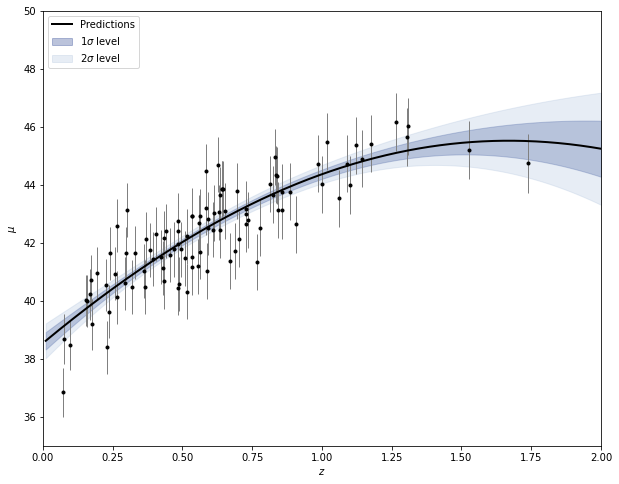

In [21]:
fig = plt.figure(figsize=(10, 8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, y_pred, "-k", linewidth=2, label="Predictions")

plt.fill_between(z, y_pred - dy_pred, y_pred + dy_pred, color='#1E3A8A', alpha=0.3, label = '1$\\sigma$ level')
plt.fill_between(z, y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='#B0C4DE', alpha=0.3, label = '2$\\sigma$ level')

plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc="upper left")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Let's do some parameter estimation

In [ ]:
# do the emcee thing, nested sampling or emcee with savage dickey
# you can redo all without the two high redshift points
# you can clone data through the right distribution of redshift (not uniform)

In [22]:
import emcee
import scipy.stats as scistats
import corner
import dynesty

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [23]:
def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

In [24]:
def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def log_prior(theta):
    Om,H0 = theta
    if 0.1 < Om < 1 and 50.0 < H0 < 100.0:
        return 0.0
    
    return -np.inf

def log_posterior(theta):
    return LogLikelihood(theta) + log_prior(theta)

In [25]:
nsteps = int(1e4)
nwalkers, ndim = 5, 2
starting_guess = np.array([0.5, 80]) + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(starting_guess, nsteps);

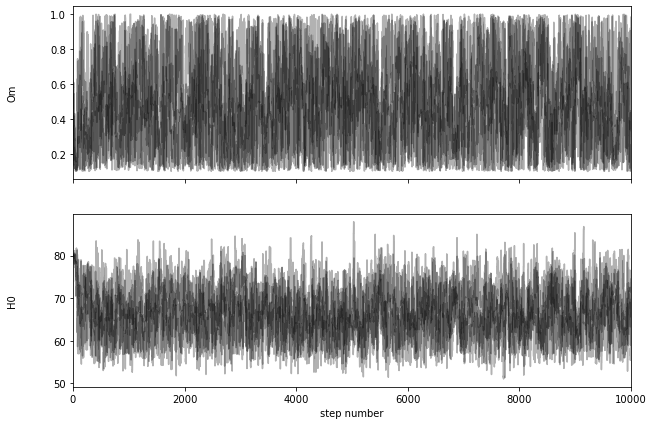

In [26]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["Om", "H0"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [27]:
tau = sampler.get_autocorr_time()
print(tau)

[50.54948862 50.06109442]


In [28]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(985, 2)


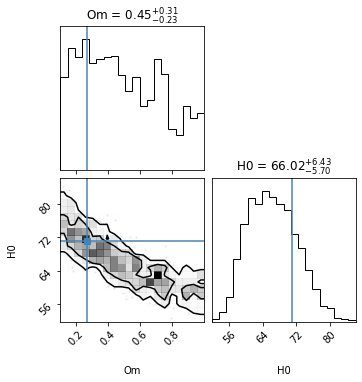

In [29]:
fig = corner.corner(
    flat_samples, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

In [30]:
zlin = np.linspace(0,2,100)[1:]

(35.0, 50.0)

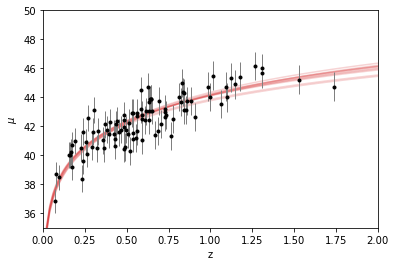

In [31]:
for Om,H0, in flat_samples[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

I now check the importance of the last two datapoints by redoing the MCMC sampling but without those two.

In [32]:
rm_idx = np.where(z_sample > 1.5)

z_sample_new = np.delete(z_sample, rm_idx)
mu_sample_new = np.delete(mu_sample, rm_idx)
dmu_new = np.delete(dmu, rm_idx)

In [36]:
def LogLikelihood_nolastpoints(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample_new, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu_new).logpdf(mu_sample_new))

def log_posterior_nolastpoints(theta):
    return LogLikelihood_nolastpoints(theta) + log_prior(theta)

In [37]:
nsteps = int(1e4)
nwalkers, ndim = 5, 2
starting_guess = np.array([0.5, 80]) + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_nolastpoints)
sampler.run_mcmc(starting_guess, nsteps);

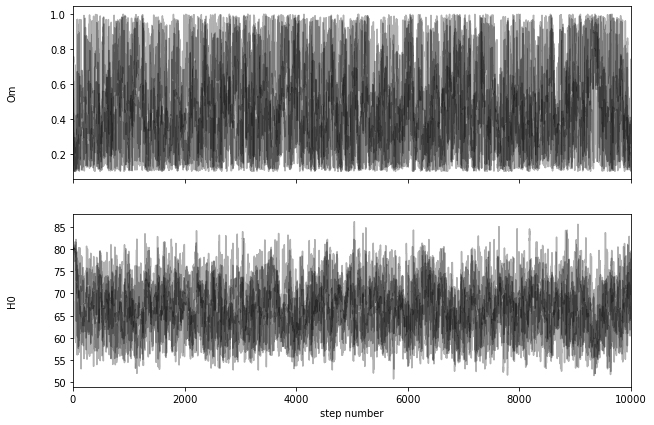

In [38]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["Om", "H0"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [39]:
tau = sampler.get_autocorr_time()
print(tau)

[46.93099376 52.02218159]


In [40]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(945, 2)


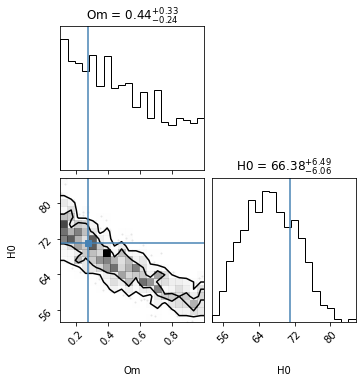

In [41]:
fig = corner.corner(
    flat_samples, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

(35.0, 50.0)

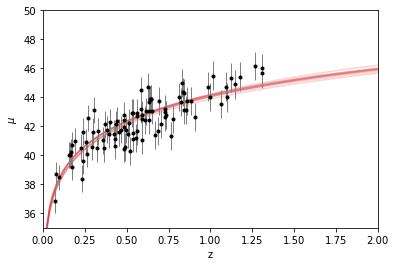

In [43]:
for Om,H0, in flat_samples[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample_new, mu_sample_new, dmu_new, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

I can notice that, in respect to the previous fit, the width of the samples seems to get more narrow.

PCA (non capisco il senso)

In [52]:
X = np.column_stack((z_sample, mu_sample))

In [105]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_fit = pca.fit_transform(X_scaled)

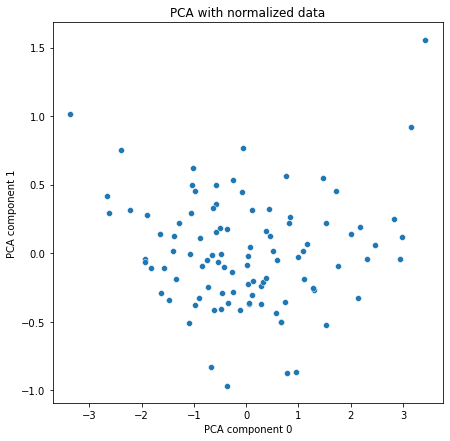

Variance on the first component: 0.917080533529743
Variance on the second component: 0.08291946647025719


In [108]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=X_fit[:,0], y=X_fit[:,1])
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")

plt.title("PCA with normalized data")
plt.show()

print("Variance on the first component:", pca.explained_variance_ratio_[0])
print("Variance on the second component:", pca.explained_variance_ratio_[1])

This result tells me that the most of the information is contained probably in the Hubble parameter, while the dark energy parameter seems to not be necessary in the case of this scenario.